# Gulf of Mexico - Method 2

The goal is to create an automatic detection method of cyclones based on the SST variance. In fact, a cyclone uses the heat of the ocean to grow and then its track is recognizable by a dimiution of the sea surface temperature which leads to a fast augmentation of the variance. In this notebook, we compute the detection of the peaks of variance and then count the cyclones. We also visualize the track of the cyclone thanks to a GIF. 

This code is written to be run on google colab.

## Introduction

### Before starting

You need to install Basemap and mlinsights. Do it only once.

In [1]:
!pip install basemap
!pip install mlinsights
!pip install pwlf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import libraries:


In [2]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
from scipy.stats.mstats import zscore
import warnings
import matplotlib.pyplot as plt
import xarray as xr
import plotly.express as px #to create dynamic graphs
import pwlf #to compute piecewise linear functions 
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(15,7) # graph size

Populating the interactive namespace from numpy and matplotlib


### Declare functions:
- plot_im (plot satellite image with geographic coordinates)

In [3]:
# function to plot images  
def plot_im(lon,lat,im,size_points,var_name,vmin,vmax):
    
    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)
    
    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='robin',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)
    
    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    #im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    plt.clim(vmin,vmax) #add legend limit
    cb.set_label(var_name,fontsize=15)

**Connection to the GCP:**

First, we have to connect to the Google Cloud Platform. Enter the login "bigdataocean2020@gmail.com" and password "bdoimt2023". Do it only once. We will maybe need an authentication: contact at pierre.tandeo@imt-atlantique.fr.

In [4]:
import os
os.environ['USE_AUTH_EPHEM'] = '0'

from google.colab import auth
auth.authenticate_user()

The Google Cloud Platform has set up a tool to handle large databases. This is called "BigQuery" and it is based on the NoSQL ("Not only SQL") language. The syntaxe in BigQuery is very similar to the pandas example given in the first practice. SQL language is suitable to manipulate and compute basic statistics such as the mean, standard deviation, minimum, maximum, correlation, etc..

## First visualization

This part gathers the visualizations and reflections for the realization of our detection method. These visualization are on the Gulf of Mexico.

### Get dataset

In [5]:
%%bigquery outputMexique --project alert-ground-261008
SELECT year,month, day, lon, lat, sst
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lon>=256 AND lon<=282 AND lat>=18 AND lat<=32
ORDER BY year, month, day

Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
# first rows of the dataframe
outputMexique.head()

,year,month,day,lon,lat,sst
0,1998,1,2,274.375,25.875,25.50
1,1998,1,2,273.625,29.375,19.50
2,1998,1,2,281.875,31.625,23.10
3,1998,1,2,280.875,24.125,24.45
4,1998,1,2,273.625,29.125,19.80


In [7]:
outputMexique['time']=pd.to_datetime(outputMexique[['year','month','day']]) #create the date column %year-%month-%day
outputMexique.drop(columns=['year','month','day'],inplace=True)
outputMexique

,lon,lat,sst,time
0,274.375,25.875,25.50,1998-01-02
1,273.625,29.375,19.50,1998-01-02
2,281.875,31.625,23.10,1998-01-02
3,280.875,24.125,24.45,1998-01-02
4,273.625,29.125,19.80,1998-01-02
...,...,...,...,...
14936123,264.875,22.375,25.95,2016-01-01
14936124,281.125,29.875,25.80,2016-01-01
14936125,264.625,24.125,25.05,2016-01-01
14936126,281.875,27.875,25.50,2016-01-01


In [8]:

Mexique=outputMexique.set_index(['time','lon','lat']) #set multiple index

xarrayMex=Mexique.to_xarray() #convert to a xarray to work with multi-coordinates
xarrayMex

<xarray.Dataset>
Dimensions:  (time: 6574, lon: 77, lat: 56)
Coordinates:
  * time     (time) datetime64[ns] 1998-01-02 1998-01-03 ... 2016-01-01
  * lon      (lon) float64 262.9 263.1 263.4 263.6 ... 281.1 281.4 281.6 281.9
  * lat      (lat) float64 18.12 18.38 18.62 18.88 ... 31.12 31.38 31.62 31.88
Data variables:
    sst      (time, lon, lat) float64 nan nan nan nan ... 26.25 26.55 26.25

### Compute variance

In [9]:
var=xarrayMex.var(dim=["lat",'lon']) #compute the variance with the built-in function
var


<xarray.Dataset>
Dimensions:  (time: 6574)
Coordinates:
  * time     (time) datetime64[ns] 1998-01-02 1998-01-03 ... 2016-01-01
Data variables:
    sst      (time) float64 5.622 5.63 5.741 5.811 ... 2.258 2.051 1.915 1.83

In [10]:
time_var=var.to_pandas()
time_var.reset_index(inplace=True)
time_var.rename(columns={"sst": "variance_sst"},inplace=True) #remane sst to variance_sst
time_var

,time,variance_sst
0,1998-01-02,5.621755
1,1998-01-03,5.630172
2,1998-01-04,5.740568
3,1998-01-05,5.810964
4,1998-01-06,5.463557
...,...,...
6569,2015-12-28,2.095868
6570,2015-12-29,2.258423
6571,2015-12-30,2.050726
6572,2015-12-31,1.915431


### Visualizations of the SST variance

We are going to plot the SST variance in function of the time on all the dataset.

In [11]:
sst=px.scatter(time_var, x='time',y='variance_sst',hover_data=['time'],title='SST Variance over time')
sst.show()

We notice that the signal is **seasonal**. The variance is high in winter (many different temperatures) and low in summer (ocean is generally warm and at the same temperature).

We are going to plot the signal on only one year. We choose 2005.

In [12]:
year_var=time_var.loc[time_var['time'].dt.year.isin([2005])]

sst=px.scatter(year_var, x='time',y='variance_sst',hover_data=['time'],title='SST Variance over time')
sst.show()

The three small peaks observed during the phase of small variances correspond to cyclones.

In order to reduce the noise on the signal, we perform a sliding average of the variance. We thus obtain a **smoothed signal**. 

In [13]:
#rolling average of the variance with a window of 10.
time_var['smoothed_var']=time_var['variance_sst'].rolling(10,min_periods=1,center=True).mean()

sst=px.scatter(time_var, x='time',y='smoothed_var',hover_data=['time'],title='Smoothed SST Variance over time')
sst.show()


In [14]:
year_var=time_var.loc[time_var['time'].dt.year.isin([2005])]

sst=px.scatter(year_var, x='time',y='smoothed_var',hover_data=['time'],title='Smoothed SST Variance in 2005')
sst.show()


We can see that we obtain a smoothed signal with less noise. In a year, we notice that in winter the variance is very strong and in summer very weak with a transition phase. In order to represent these four phases, we will perform a **segmented linear regression**.

In [15]:
time_var['ts'] = time_var['time'].values.astype(np.int64) // 10 ** 9 #timestamp column
year_var=time_var.loc[time_var['time'].dt.year.isin([2005])]

In [16]:
#conversion to numpy
X = year_var['ts'].to_numpy() 
Y= year_var['smoothed_var'].to_numpy()

In [17]:
my_pwlf = pwlf.PiecewiseLinFit(X, Y) #segmented linear regression
breaks_time = my_pwlf.fit(4) #get the break time i.e., the phase change times.
print(breaks_time)

[1.10453760e+09 1.11509717e+09 1.11780077e+09 1.13189696e+09
 1.13598720e+09]


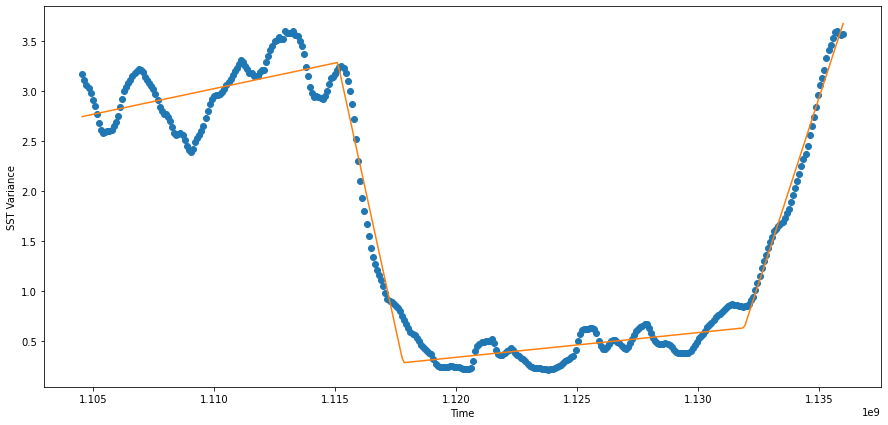

In [18]:
x_hat = X
y_hat = my_pwlf.predict(x_hat)

plt.figure()
plt.plot(X, Y, 'o')
plt.plot(x_hat, y_hat, '-')
xlabel('Time')
ylabel('SST Variance')
plt.show()

### Katrina study

In [19]:
annee_var=time_var.loc[time_var['time'].dt.year==2005]

sst=px.scatter(annee_var, x='time',y='variance_sst',hover_data=['time'],title='SST Variance in 2005')
sst.show()

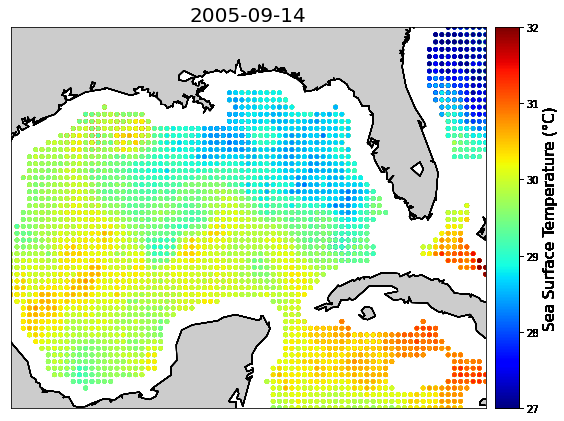

In [20]:
j = 10
for i in range(23,32):
  Katrina=outputMexique.loc[outputMexique.time=='2005-08-'+str(i)]
  plot_im(Katrina.lon, Katrina.lat, Katrina.sst, 20, 'Sea Surface Temperature (°C)',27,32)
  title('2005-08-'+str(i), size=20)
  plt.savefig("Katrina"+str(j)+".jpg")
  j +=1

for i in range(1,15):
  Katrina=outputMexique.loc[outputMexique.time=='2005-09-'+str(i)]
  plot_im(Katrina.lon, Katrina.lat, Katrina.sst, 20, 'Sea Surface Temperature (°C)',27,32)
  title('2005-09-'+str(i), size=20)
  plt.savefig("Katrina"+str(j)+".jpg")
  j+=1

In [21]:
import imageio as iio
frames = np.stack([iio.imread("Katrina" + str(i) + ".jpg") for i in range(10,33)], axis = 0)

img = iio.mimwrite('Katrina.gif', frames)
img

### Map Study
The following code generates a GIF to visualise the evolution of the SST in the studied zone. The GIF is available in the "Files section" on the left.

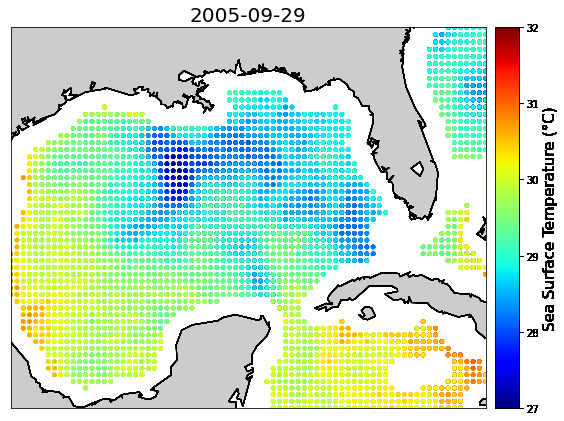

In [22]:
j = 10
for i in range(1,30):
  Katrina=outputMexique.loc[outputMexique.time=='2005-09-'+str(i)]
  plot_im(Katrina.lon, Katrina.lat, Katrina.sst, 20, 'Sea Surface Temperature (°C)',27,32)
  title('2005-09-'+str(i), size=20)
  plt.savefig("September"+str(j)+".jpg")
  j +=1

frames = np.stack([iio.imread("September" + str(i) + ".jpg") for i in range(10,33)], axis = 0)

img = iio.mimwrite('September.gif', frames)
img


## Cyclone Automatic Detection with SST

### Get Dataset with BigQuery

In [23]:
%%bigquery output --project alert-ground-261008
SELECT year,month, day, lon, lat, sst
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lon>=256 AND lon<=282 AND lat>=18 AND lat<=32
ORDER BY year, month, day

Query is running:   0%|          |

Downloading:   0%|          |

In [24]:
outputMexique=output.copy()
outputMexique['time']=pd.to_datetime(outputMexique[['year','month','day']])
years=outputMexique.year.unique() #get the years of the dataset
outputMexique.drop(columns=['year','month','day'],inplace=True)
outputMexique

,lon,lat,sst,time
0,274.375,25.875,25.50,1998-01-02
1,273.625,29.375,19.50,1998-01-02
2,281.875,31.625,23.10,1998-01-02
3,280.875,24.125,24.45,1998-01-02
4,273.625,29.125,19.80,1998-01-02
...,...,...,...,...
14936123,264.875,22.375,25.95,2016-01-01
14936124,281.125,29.875,25.80,2016-01-01
14936125,264.625,24.125,25.05,2016-01-01
14936126,281.875,27.875,25.50,2016-01-01


In [25]:
outputMexique=outputMexique.set_index(['time','lon','lat']) #set multi-index

xarrayMex=outputMexique.to_xarray() #convert to an xarray to handle multi-dimensional arrays
xarrayMex

<xarray.Dataset>
Dimensions:  (time: 6574, lon: 77, lat: 56)
Coordinates:
  * time     (time) datetime64[ns] 1998-01-02 1998-01-03 ... 2016-01-01
  * lon      (lon) float64 262.9 263.1 263.4 263.6 ... 281.1 281.4 281.6 281.9
  * lat      (lat) float64 18.12 18.38 18.62 18.88 ... 31.12 31.38 31.62 31.88
Data variables:
    sst      (time, lon, lat) float64 nan nan nan nan ... 26.25 26.55 26.25

 ### Compute variance

We compute the **variance of the SST** on the latitude and the longitude

In [26]:
var=xarrayMex.var(dim=["lat",'lon']) #use the built-in function var
var

<xarray.Dataset>
Dimensions:  (time: 6574)
Coordinates:
  * time     (time) datetime64[ns] 1998-01-02 1998-01-03 ... 2016-01-01
Data variables:
    sst      (time) float64 5.622 5.63 5.741 5.811 ... 2.258 2.051 1.915 1.83

We convert the result into a dataframe easier to handle for 1 index and 1 variable.

In [27]:
df_var=var.to_pandas() #convert to Dataframe
df_var.reset_index(inplace=True) #change index => from timeIndex to number Index
df_var.rename(columns={"sst": "variance_sst"},inplace=True) #remane the column sst to variance_sst

We create a timestamp column i.e. a float column that can be handle by the algorithms.

In [28]:
df_var['ts'] = df_var['time'].values.astype(np.int64) // 10 ** 9 # create a timestamp column

We compute the **smoothed variance** to remove noise from the signal. We thus obtain the global form of the signal.

In [29]:
df_var['smoothed_var']=df_var['variance_sst'].rolling(12,min_periods=1,center=True).mean() #compute the smoothed variance to remove noise from the signal

### Peak Detection

We plot the sst variance over time and the detected picks in red.

In [30]:
from scipy.signal import find_peaks
peaks, info = find_peaks(df_var['variance_sst'], height=[0.5,2],width=[0,5])
df_peaks=df_var.iloc[peaks].copy()  #create dataframe with peaks
df_peaks['height']=info['peak_heights']
df_peaks

,time,variance_sst,ts,smoothed_var,height
131,1998-05-13,1.925397,895017600,1.822550,1.925397
142,1998-05-24,0.744118,895968000,0.759480,0.744118
146,1998-05-28,0.539975,896313600,0.565459,0.539975
252,1998-09-11,0.543259,905472000,0.410328,0.543259
282,1998-10-11,0.602619,908064000,0.575528,0.602619
...,...,...,...,...,...
6521,2015-11-10,1.340782,1447113600,1.089101,1.340782
6528,2015-11-17,1.339681,1447718400,1.233616,1.339681
6530,2015-11-19,1.322872,1447891200,1.328162,1.322872
6532,2015-11-21,1.347894,1448064000,1.420656,1.347894


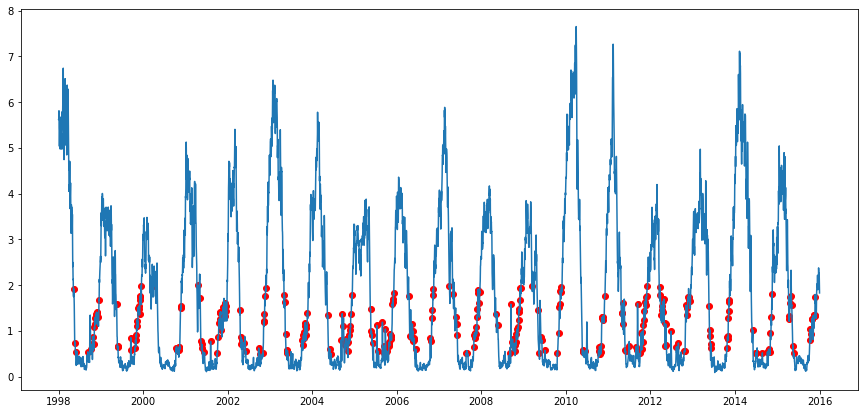

In [31]:
plt.plot(df_var['time'],df_var['variance_sst'])
plt.scatter(df_peaks['time'], df_peaks['variance_sst'],c = 'red')

The visualization is not really clear. We are going to focus on one year.

### Selection of the cyclone periods
We used a segmented linear regression method to detect summer time. A year is divided into 4 phases :
- **winter phase** (*high variance*)
- winter to **summer phase** : *transition time* (from high variance to low variance)
- summer phase i.e. **hurricanes time** (*low variance*)
- **summer to winter phase** : *transition time* (from low variance to high variance)

In [32]:
#first we used the month but we decide to detect the cyclone automaticaly with a segemented linear regression method
"""cyclone_months=[i for i in range(7,11)] #define the cyclone months
df_cyclone=df_peaks.loc[df_peaks['time'].dt.month.isin(cyclone_months)] #select the cyclone months
df_cyclone['peaks']='Yes' """

"cyclone_months=[i for i in range(7,11)] #define the cyclone months\ndf_cyclone=df_peaks.loc[df_peaks['time'].dt.month.isin(cyclone_months)] #select the cyclone months\ndf_cyclone['peaks']='Yes' "

In [33]:
frames=[] #to store all the period cyclone dataframe

#we loop over all the year
for year in years[:-1]:
  df_year_var=df_var.loc[df_var['time'].dt.year==year].copy() #get the year dataframe

  #apply the segemented linear regression method
  my_pwlf = pwlf.PiecewiseLinFit(df_year_var['ts'].to_numpy(), df_year_var['smoothed_var'].to_numpy())
  break_timestamps = my_pwlf.fit(4) #get the change time

  #check if which break timestamps are in the cyclone period 
  df_break=df_year_var.loc[df_year_var['time'].isin([np.datetime64(pd.Timestamp(e, unit='s').date()) for e in break_timestamps])][['time','variance_sst']]
  

  df_break.sort_values(by='variance_sst',inplace=True) #sort to increase variance
  df_cyclone_break=df_break.head(2) #get the row of the 2 lowest variance
  df_cyclone_break.sort_values(by='time',inplace=True) #order by time
  
  #get the dataframe corresponding to the cyclone period 
  frames.append(df_var[df_cyclone_break.index.values[0]:df_cyclone_break.index.values[1]+1])

#concat all the cyclone year period dataframe => global hurricanes period dataframe
df_cyclone_time=pd.concat(frames)

In [34]:
df_cyclone=df_peaks.loc[df_peaks['time'].isin(df_cyclone_time.time.values)] #get the peaks belonging to the cyclone period
df_cyclone['peaks']='Yes'

In [35]:
df_var['peaks']=df_cyclone['peaks']
df_var['Height']=df_peaks['height']
df_var['peaks']=np.where(df_var['peaks']=='Yes', 'Yes', 'No') #indicate if a day is peak or no
df_var

,time,variance_sst,ts,smoothed_var,peaks,Height
0,1998-01-02,5.621755,883699200,5.617550,No,NaN
1,1998-01-03,5.630172,883785600,5.582669,No,NaN
2,1998-01-04,5.740568,883872000,5.514373,No,NaN
3,1998-01-05,5.810964,883958400,5.507445,No,NaN
4,1998-01-06,5.463557,884044800,5.504845,No,NaN
...,...,...,...,...,...,...
6569,2015-12-28,2.095868,1451260800,2.102612,No,NaN
6570,2015-12-29,2.258423,1451347200,2.096392,No,NaN
6571,2015-12-30,2.050726,1451433600,2.089088,No,NaN
6572,2015-12-31,1.915431,1451520000,2.053053,No,NaN


In [36]:
sst=px.scatter(df_cyclone_time, x='time',y='variance_sst',hover_data=['time'], title='SST variance over time only on the cyclone period')
sst.show()

In [37]:
df_2005_var=df_var.loc[df_var['time'].dt.year==2005].copy()
sst=px.scatter(df_2005_var, x='time',y='variance_sst',hover_data=['time'], title='SST variance over time')
sst.show()

Limits of the method : if two cyclones occurs at the same time, we can't separate them. 

In [38]:
# create a list of our conditions
conditions = [
    (df_var['peaks']=='Yes')&((df_var['Height']<=0.9) | (df_var['variance_sst']<=1)),
    (df_var['Height']>0.9) & (df_var['variance_sst']>1)&(df_var['peaks']=='Yes'),
    (df_var['peaks']=='No')
    ]
  
# create a list of the values we want to assign for each condition
values = ['H', 'MH', '0']

# create a new column and use np.select to assign values to it using our lists as arguments
df_var['Category'] = np.select(conditions, values)
df_var


,time,variance_sst,ts,smoothed_var,peaks,Height,Category
0,1998-01-02,5.621755,883699200,5.617550,No,NaN,0
1,1998-01-03,5.630172,883785600,5.582669,No,NaN,0
2,1998-01-04,5.740568,883872000,5.514373,No,NaN,0
3,1998-01-05,5.810964,883958400,5.507445,No,NaN,0
4,1998-01-06,5.463557,884044800,5.504845,No,NaN,0
...,...,...,...,...,...,...,...
6569,2015-12-28,2.095868,1451260800,2.102612,No,NaN,0
6570,2015-12-29,2.258423,1451347200,2.096392,No,NaN,0
6571,2015-12-30,2.050726,1451433600,2.089088,No,NaN,0
6572,2015-12-31,1.915431,1451520000,2.053053,No,NaN,0


In [39]:
df_var['Category'].value_counts()

0     6471
H       82
MH      21
Name: Category, dtype: int64

## Resultat

Let's check the results obtained by our **automatic cyclone detection**.

### Visualization of the detected cyclones for the year 2005

In [40]:
df_2005_var=df_var.loc[df_var['time'].dt.year.isin([2005])]

sst=px.scatter(df_2005_var, x='time',y='variance_sst',hover_data=['time','Height'],color='Category', title='SST variance over time')
sst.show()

### Statistics of results

Let's count the number of cyclone per year.

In [41]:
df_cyclone=df_var.loc[df_var['Category']!='0'].copy()
df_group=df_cyclone.groupby([df_cyclone.time.dt.year,'Category'])['peaks','Height'].count()

df_group_pivot=pd.pivot_table(df_group, values='peaks', index=['time'],
                    columns=['Category'], aggfunc=np.sum)

In [42]:
df_group.reset_index(inplace=True)

In [43]:
fig = px.bar(df_group, x="time", y="peaks", color="Category", title="Number of cyclones per year")
fig.show()

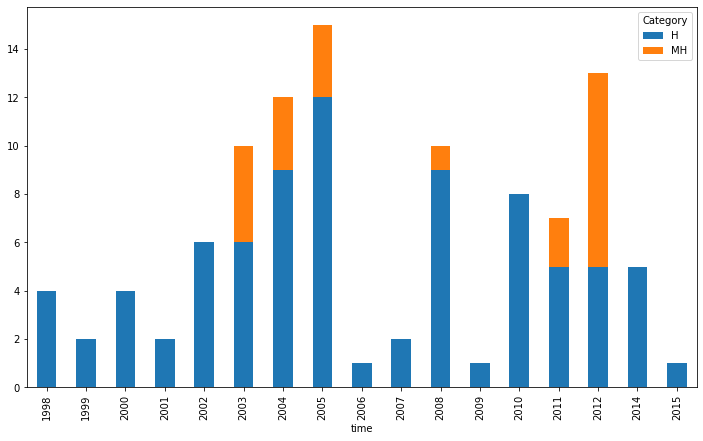

In [44]:
pylab.rcParams['figure.figsize']=(12,7) # graph size
df_group_pivot.plot(kind='bar', stacked=True)

### Verification

Let's compare the results to real cyclones.

In [45]:
#open the dataset listing all the hurricanes in the Gulf of Mexico
df_true_cyclone=pd.read_csv('/content/sample_data/ibtracs-gulf of mexico-1998-2015.csv', parse_dates=['ISO_TIME'])
df_true_cyclone=df_true_cyclone.loc[df_true_cyclone['CATEGORY'].isin([str(i) for i in range (1,6)])].copy() #get only the cyclone
df_true_cyclone['time']=df_true_cyclone['ISO_TIME'].dt.date #convert ISO time to date time
#df_true_cyclone.loc[(df_true_cyclone['ISO_TIME'].dt.year==2005) & (df_true_cyclone['ISO_TIME'].dt.month==8)]

In [46]:
df_true_cyclone.loc[(df_true_cyclone['ISO_TIME'].dt.year==2005)]

,LAT,LON,SID,USA_WIND,CATEGORY,NSEC_TIME,ISO_TIME,time
1471,28.500,269.700,2005185N18273,65.0,1,1120608000000000000,2005-07-06 00:00:00,2005-07-06
1472,29.200,269.900,2005185N18273,65.0,1,1120618800000000000,2005-07-06 03:00:00,2005-07-06
1478,20.300,281.600,2005186N12299,110.0,3,1120802400000000000,2005-07-08 06:00:00,2005-07-08
1479,20.579,281.012,2005186N12299,120.0,4,1120813200000000000,2005-07-08 09:00:00,2005-07-08
1480,20.900,280.500,2005186N12299,130.0,4,1120824000000000000,2005-07-08 12:00:00,2005-07-08
...,...,...,...,...,...,...,...,...
1753,25.594,277.728,2005289N18282,106.0,3,1130144400000000000,2005-10-24 09:00:00,2005-10-24
1754,25.900,278.300,2005289N18282,105.0,3,1130149800000000000,2005-10-24 10:30:00,2005-10-24
1755,26.200,279.000,2005289N18282,95.0,2,1130155200000000000,2005-10-24 12:00:00,2005-10-24
1756,27.004,280.140,2005289N18282,100.0,3,1130166000000000000,2005-10-24 15:00:00,2005-10-24


In [47]:
df_true_cyclone['SID'].unique().size

42

The  actual number hurricanes in the Gulf of Mexico for the period 1998-2015 is **42** acording to the dataset.

In our method, cyclones are detected by the appearance of cold water, but this occurs a few days after the actual passage of the cyclone. So we have a time lag between what we detect and what was actually recorded. This **time lag is set at a maximum of 6 days**.

In [48]:
#Creation of the delayed columns
df_true_cyclone['delayed_date1']=df_true_cyclone['time'] + pd.Timedelta(days=1) #1 day late
df_true_cyclone['delayed_date2']=df_true_cyclone['time'] + pd.Timedelta(days=2) #2 days late
df_true_cyclone['delayed_date3']=df_true_cyclone['time'] + pd.Timedelta(days=3) #3 days late
df_true_cyclone['delayed_date4']=df_true_cyclone['time'] + pd.Timedelta(days=4) #4 days late
df_true_cyclone['delayed_date5']=df_true_cyclone['time'] + pd.Timedelta(days=5) #5 days late
df_true_cyclone['delayed_date6']=df_true_cyclone['time'] + pd.Timedelta(days=6) #6 days late

#Creations of the set of dates corresponding to a cyclone
true_date=set(df_true_cyclone['delayed_date1'].to_numpy()).union(set(df_true_cyclone['time'].to_numpy()))
true_date=true_date.union(set(df_true_cyclone['delayed_date2'].to_numpy()))
true_date=true_date.union(set(df_true_cyclone['delayed_date3'].to_numpy()))
true_date=true_date.union(set(df_true_cyclone['delayed_date4'].to_numpy()))
true_date=true_date.union(set(df_true_cyclone['delayed_date5'].to_numpy()))
true_date=true_date.union(set(df_true_cyclone['delayed_date6'].to_numpy()))

If the date of the detected cyclone belongs to the extended set of dates of the real cyclones of the dataset then the cyclone is considered as correctly detected.

In [49]:
#TP => correctly detected (TP)
# FP => false positive (FP)
df_cyclone['Verif']=np.where(df_cyclone['time'].isin(true_date), 'TP', 'FP')
df_cyclone['Verif'].value_counts()

FP    78
TP    25
Name: Verif, dtype: int64

We have a recall of 25/42=0,59 and a precision of 25/78+25 = 0,24

In [50]:
df_cyclone.loc[df_cyclone['Verif']=='FP']

,time,variance_sst,ts,smoothed_var,peaks,Height,Category,Verif
252,1998-09-11,0.543259,905472000,0.410328,Yes,0.543259,H,FP
282,1998-10-11,0.602619,908064000,0.575528,Yes,0.602619,H,FP
289,1998-10-18,0.708450,908668800,0.553473,Yes,0.708450,H,FP
296,1998-10-25,0.874741,909273600,0.624524,Yes,0.874741,H,FP
1014,2000-10-12,0.623326,971308800,0.474513,Yes,0.623326,H,FP
...,...,...,...,...,...,...,...,...
6022,2014-06-29,0.513840,1404000000,0.387340,Yes,0.513840,H,FP
6025,2014-07-02,0.517621,1404259200,0.428583,Yes,0.517621,H,FP
6079,2014-08-25,0.520523,1408924800,0.340930,Yes,0.520523,H,FP
6123,2014-10-08,0.541854,1412726400,0.328834,Yes,0.541854,H,FP


In [51]:
df_var['Verif']=df_cyclone['Verif']
df_var['Verif'].fillna(0, inplace=True) #fill 0 for the non-cyclone data

### Results for 2015

In [52]:
df_2005_var=df_var.loc[df_var['time'].dt.year.isin([2005])]

sst=px.scatter(df_2005_var, x='time',y='variance_sst',hover_data=['time','Height'],color='Verif', title='SST variance over time')
sst.show()

In 2005, in the Gulf of Mexico, litterature records the following cyclones:
- 3-7 july : Cindy, H
- 4-13 july : **Dennis** MH
- 11-21 july : **Emily** MH
- 23-30 august : **Katrina** MH
- 6-17 sept : **Ophelia** H
- 18-26 sept :  **Rita** MH
- 1-5 oct : **Stan** H

The cyclones in **bold** are detected by our method. Hurricaine Cindy and Hurricaine Dennis are at the same time so their peaks are probably supperposed. We can see that all the major hurraicaines are detected and well classified as a major hurricaine.